### Prep Work

In [1]:
# Import general libraries
import pandas as pd
import numpy as np

import datetime
import warnings; warnings.simplefilter('ignore')

np.random.seed(42)

In [2]:
# Import NLP libraries
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [3]:
from sklearn.feature_extraction import text, stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
# Import Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

In [5]:
# Import Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Increase size of dataframe
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_rows', 100000)
pd.options.display.max_colwidth = 500

### Read lemmatized and tokenized data

In [7]:
data = pd.read_csv('../data/processed_data.csv', index_col=0)

In [8]:
# ATA code should be an object with leading zeros
data['ata4_code'] = data['ata4_code'].astype(str).map(lambda x: x.zfill(4))

In [9]:
data.head(2)

,fleet,problem_log,corrective_action,delay_code,station_delay_minutes,d&c_category,ata4_code,ata4_desc
1432,A319-131,crew reported rubber smell in cabin f rom rows 1 to rows 21 newman tomc samc text wo 15092916 crew also reported that smell had quick ly disapated newman tomc,no defects noted in galley equip cabin equip aevc equipment and air conditioning equipment per tsm 05 51 00 fo llowed tsm 21 00 00 810 801 performed engine and apu runs and no bu rnt rubber smell present newman tomc opblm newman jay,TA,80,Delay>15mins,2520,passenger compartment
1927,A319-131,loud chatter and vibration heard and felt in ac,reset valve in water line behind coffee maker aft galley noise stopped,TA,29,Delay>15mins,2530,galleys


## Use Bag of Words Modeling

### Generate tokens using CountVectorizer

In [10]:
# Create my_stop_words in case we want to add additional words 
my_stop_words = list(stop_words.ENGLISH_STOP_WORDS) + ['am', 'ops', 'ref']

In [11]:
data['log_action'] = data['problem_log'] + data['corrective_action']

In [12]:
# Instantiate Countvectorizer
cvec = CountVectorizer(stop_words=my_stop_words, ngram_range=(1,2),
                       max_features=10_000)   

# Fit and transform Count Vectorizer to log_action
cvec_words_log_action = pd.DataFrame(cvec.fit_transform(data['log_action']).toarray(),
                        columns=cvec.get_feature_names())

# Identify top 20 words for log action using CountVectorizer
top_cvec_words_log_action = cvec_words_log_action.sum(axis=0).sort_values(ascending=False).head(20)
print(f" Most frequent words for log_action using Countvectorizer: \n\n{top_cvec_words_log_action}")

 Most frequent words for log_action using Countvectorizer: 

seat          5959
door          2398
replaced      2382
25            1943
check         1855
aft           1850
good          1757
removed       1634
galley        1374
latch         1225
okay          1207
normal        1140
amm           1027
missing       1019
broken         993
slide          955
cover          937
forward        910
29             853
check good     845
dtype: int64


### ### Prepare Count Vectorized data for model

In [13]:
# Dummy out fleet and delay code
data_dummied = pd.get_dummies(data, columns=['fleet', 'delay_code'],
                              drop_first=True)

In [14]:
#Drop unnecessary columns
reduced_data = data_dummied.drop(columns = ['log_action','problem_log',
                                           'corrective_action','d&c_category',
                                           'ata4_desc'])

In [15]:
vectorized_data_cvec = pd.concat([reduced_data.reset_index(drop=True),
                             cvec_words_log_action.reset_index(drop=True)],
                                 axis=1)  

### Save Count vectorized data as csv file

In [16]:
# Save the full data file - all ATA codes
vectorized_data_cvec.to_csv('../data/vectorized_data_cvec.csv')


### Generate tokens using TfidfVectorizer

In [17]:
# Create my_stop_words in case we want to add additional words 
my_stop_words = list(stop_words.ENGLISH_STOP_WORDS) + ['am', 'ops', 'ref']

In [18]:
data['log_action'] = data['problem_log'] + data['corrective_action']

In [19]:
# Instantiate Tfidfvectorizer
tvec = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,2),
                       max_features=10_000)   

# Fit and transform Tfidf Vectorizer to log_action
tvec_words_log_action = pd.DataFrame(tvec.fit_transform(data['log_action']).toarray(),
                        columns=tvec.get_feature_names())

# Identify top 20 words for log action using TfidfVectorizer
top_tvec_words_log_action = tvec_words_log_action.sum(axis=0).sort_values(ascending=False).head(20)
print(f" Most frequent words for log_action using Tfidfvectorizer: \n\n{top_tvec_words_log_action}")

 Most frequent words for log_action using Tfidfvectorizer: 

seat        451.630204
door        225.150032
replaced    204.645548
aft         183.199384
check       180.819083
good        177.427191
latch       163.629950
25          152.406339
removed     151.821686
galley      145.443381
cushion     143.102829
okay        133.739713
normal      133.069073
cover       132.754090
missing     127.851476
broken      122.242195
bin         118.983109
ok          110.892147
recline     110.220938
tray        109.698457
dtype: float64


### Build Wordcloud for combined problem log + corrective action

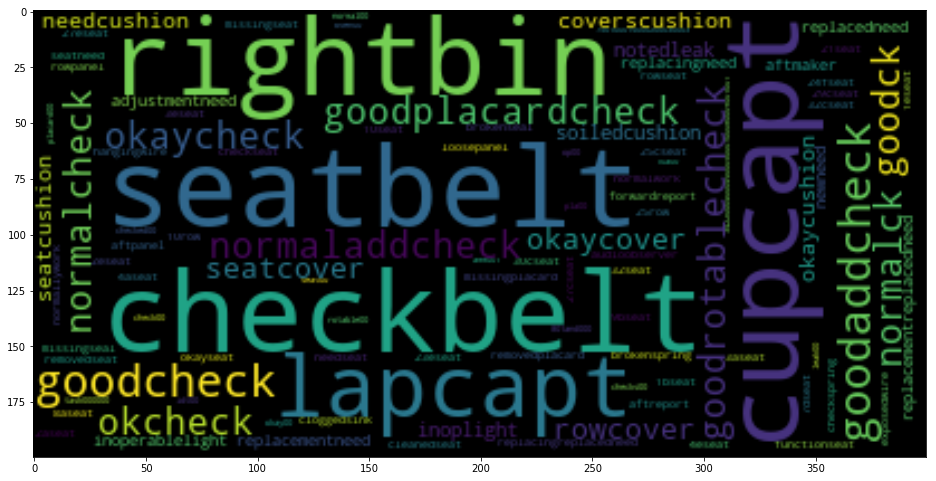

In [20]:
totalText=''
for x in tvec_words_log_action:
    totalText=totalText+x
from wordcloud import WordCloud
wc=WordCloud(background_color='black',max_font_size=50).generate(totalText)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation='bilinear');

### ### Prepare Count Vectorized data for model

In [21]:
# Dummy out fleet and delay code
data_dummied = pd.get_dummies(data, columns=['fleet', 'delay_code'],
                              drop_first=True)

In [22]:
#Drop unnecessary columns
reduced_data = data_dummied.drop(columns = ['log_action','problem_log',
                                           'corrective_action','d&c_category',
                                           'ata4_desc'])

In [23]:
vectorized_data_tvec = pd.concat([reduced_data.reset_index(drop=True),
                             tvec_words_log_action.reset_index(drop=True)],
                                 axis=1)  

### Save TFIDF vectorized data as csv file

In [24]:
# Save the full data file - all ATA codes
vectorized_data_tvec.to_csv('../data/vectorized_data_tvec.csv')